In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import percentileofscore, pearsonr, spearmanr
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
def loadPrices():
    fn="../prices.txt"
    global nt, nInst
    df=pd.read_csv(fn, sep=r'\s+', header=None, index_col=None)
    (nt,nInst) = df.shape
    return nt, nInst, (df.values).T

In [ ]:
# import data
(nt, nInst, prcAll) = loadPrices()
prcTest = prcAll[:, :450]
prcCheck = prcAll[:, 450:600]
prcEval = prcAll[:, 600:]

In [ ]:
# Summary: What Pearson Correlation on Log Returns Really Means
# You're asking: "When Asset A moves up or down more than usual, does Asset B also tend to move in the same direction, at the same time, and by how much?"

# By using log returns instead of prices: You're removing trend and scale, and looking purely at the rhythm of movement between two instruments.
def compute_correlation_matrix(prc_matrix, 
                               smooth=False, 
                               smooth_window=5, 
                               use_log_returns=True, 
                               method="pearson"):
    """
    Computes correlation and p-value matrices from returns (log or percentage),
    with optional smoothing and method choice between Pearson and Spearman.

    Parameters:
        prc_matrix (ndarray): (n_instruments, n_days) price matrix
        smooth (bool): Whether to smooth returns before correlation
        smooth_window (int): Window size for smoothing
        use_log_returns (bool): If True, use log returns; else use percentage returns
        method (str): "pearson" (default) or "spearman"

    Returns:
        corr_matrix (ndarray): Correlation coefficients matrix
        pval_matrix (ndarray): P-value matrix
    """
    n = prc_matrix.shape[0]

    # Calculate returns
    if use_log_returns:
        returns = np.diff(np.log(prc_matrix), axis=1)
    else:
        returns = np.diff(prc_matrix, axis=1) / prc_matrix[:, :-1]

    # Optional smoothing
    if smooth:
        kernel = np.ones(smooth_window) / smooth_window
        returns = np.array([
            np.convolve(r, kernel, mode='valid')
            for r in returns
        ])

    # Prepare matrices
    corr_matrix = np.zeros((n, n))
    pval_matrix = np.zeros((n, n))

    # Compute correlations
    for i in range(n):
        for j in range(n):
            if i == j:
                corr_matrix[i, j] = 1.0
                pval_matrix[i, j] = 0.0
            else:
                if method == "pearson":
                    r, p = pearsonr(returns[i], returns[j])
                elif method == "spearman":
                    r, p = spearmanr(returns[i], returns[j])
                else:
                    raise ValueError("Method must be 'pearson' or 'spearman'")
                corr_matrix[i, j] = r
                pval_matrix[i, j] = p

    return corr_matrix, pval_matrix

def plot_correlation_heatmap(corr_matrix, title="Correlation Matrix Heatmap"):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',       # red = negative, blue = positive
        vmin=-1, vmax=1,       # range of correlation values
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_fdr_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.05, title="FDR-Significant Correlation Heatmap"):
    """
    Plots a heatmap of the correlation matrix, masking correlations that are not
    statistically significant after FDR correction.

    Parameters:
        corr_matrix (ndarray): Correlation coefficient matrix (n x n)
        pval_matrix (ndarray): Corresponding p-value matrix (n x n)
        alpha (float): FDR-adjusted significance threshold (default = 0.05)
        title (str): Plot title
    """
    # Flatten and correct p-values using FDR (Benjamini-Hochberg)
    flat_pvals = pval_matrix.flatten()
    rejected, corrected_pvals = fdrcorrection(flat_pvals, alpha=alpha)

    # Reshape rejection mask to original matrix shape
    fdr_mask = ~rejected.reshape(pval_matrix.shape)  # Mask = not significant
    np.fill_diagonal(fdr_mask, True)  # Always mask diagonal

    # Plot heatmap with non-significant values masked
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        mask=fdr_mask,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f"{title} (α = {alpha})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
def adjust_pvals_fdr(pval_matrix, alpha=0.05):
    """
    Applies FDR correction to a p-value matrix and returns a boolean mask of significance.
    """
    pvals_flat = pval_matrix.flatten()
    rejected, pvals_corrected = fdrcorrection(pvals_flat, alpha=alpha)
    return rejected.reshape(pval_matrix.shape)

def plot_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.05, title="Significant Correlation Heatmap"):
    """
    Plots a heatmap of the correlation matrix, masking non-significant correlations.

    Parameters:
        corr_matrix (ndarray): Correlation coefficient matrix
        pval_matrix (ndarray): Corresponding p-value matrix
        alpha (float): Significance level (default = 0.05)
        title (str): Plot title
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Create a mask for non-significant values (p > alpha)
    mask = (pval_matrix > alpha)

    # Optionally mask the diagonal too (self-correlations always = 1)
    np.fill_diagonal(mask, True)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f"{title} (α = {alpha})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
def get_top_correlated_pairs(corr_matrix, top_n=5):
    """
    Returns the top N most strongly positively correlated instrument index pairs
    from a correlation matrix (excluding diagonal/self-correlations).

    Parameters:
        corr_matrix (ndarray): A symmetric NxN correlation matrix
        top_n (int): Number of top pairs to return

    Returns:
        List of tuples: (instrument_i, instrument_j, correlation)
    """
    # Get indices of upper triangle, excluding diagonal
    n = corr_matrix.shape[0]
    upper_tri_indices = np.triu_indices(n, k=1)

    # Extract the upper triangle values and corresponding index pairs
    corr_values = corr_matrix[upper_tri_indices]
    index_pairs = list(zip(upper_tri_indices[0], upper_tri_indices[1]))

    # Sort by correlation values descending
    sorted_pairs = sorted(zip(index_pairs, corr_values), key=lambda x: x[1], reverse=True)

    # Return top N
    return [(i, j, round(val, 4)) for ((i, j), val) in sorted_pairs[:top_n]]

def lead_lag_correlation_heatmap(returns, target_idx=0, max_lag=10, method='pearson'):
    """
    Plots a heatmap of lagged correlations between a target instrument and all others.

    Parameters:
        returns (ndarray): (n_instruments, n_days) return matrix (log or %)
        target_idx (int): Index of the instrument to compare against
        max_lag (int): Max number of lags to check (both positive and negative)
        method (str): 'pearson' or 'spearman'
    """
    n_instr, n_days = returns.shape
    lags = range(-max_lag, max_lag + 1)
    target = (returns[target_idx] - np.mean(returns[target_idx])) / np.std(returns[target_idx])

    corr_matrix = np.zeros((n_instr, len(lags)))

    for i in range(n_instr):
        if i == target_idx:
            corr_matrix[i, :] = np.nan  # skip self
            continue
        series = (returns[i] - np.mean(returns[i])) / np.std(returns[i])
        for j, lag in enumerate(lags):
            if lag < 0:
                x = series[-lag:]
                y = target[:lag]
            elif lag > 0:
                x = series[:-lag]
                y = target[lag:]
            else:
                x = series
                y = target

            if method == 'pearson':
                corr = np.corrcoef(x, y)[0, 1]
            elif method == 'spearman':
                from scipy.stats import spearmanr
                corr, _ = spearmanr(x, y)
            else:
                raise ValueError("Unsupported method")
            corr_matrix[i, j] = corr

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
                xticklabels=list(lags), yticklabels=[f"Instr {i}" for i in range(n_instr)])
    plt.title(f"Lag Correlation with Instrument {target_idx}", fontsize=16)
    plt.xlabel("Lag (days)")
    plt.ylabel("Other Instruments")
    plt.tight_layout()
    plt.show()

def lead_lag_correlation_heatmap_with_mask(
    returns,
    target_idx=0,
    max_lag=10,
    method='pearson',
    corr_threshold=0.0,
    tickers=None
):
    """
    Computes and plots lead-lag correlation heatmap between a target instrument and all others,
    with masking based on a correlation threshold.

    Parameters:
        returns (ndarray): (n_instruments, n_days) return matrix
        target_idx (int): Index of the target instrument
        max_lag (int): Max lag (both positive and negative)
        method (str): 'pearson' or 'spearman'
        corr_threshold (float): Minimum |correlation| to show
        tickers (list of str, optional): Ticker labels for instruments

    Returns:
        corr_matrix (ndarray): Full lag correlation matrix
        mask (ndarray): Boolean mask (True = hidden)
    """
    n_instr, n_days = returns.shape
    lags = range(-max_lag, max_lag + 1)
    target = (returns[target_idx] - np.mean(returns[target_idx])) / np.std(returns[target_idx])

    corr_matrix = np.zeros((n_instr, len(lags)))

    for i in range(n_instr):
        if i == target_idx:
            corr_matrix[i, :] = np.nan
            continue

        series = (returns[i] - np.mean(returns[i])) / np.std(returns[i])

        for j, lag in enumerate(lags):
            if lag < 0:
                x = series[-lag:]
                y = target[:lag]
            elif lag > 0:
                x = series[:-lag]
                y = target[lag:]
            else:
                x = series
                y = target

            if method == 'pearson':
                corr = np.corrcoef(x, y)[0, 1]
            elif method == 'spearman':
                corr, _ = spearmanr(x, y)
            else:
                raise ValueError("Unsupported method: use 'pearson' or 'spearman'")

            corr_matrix[i, j] = corr

    # Create mask for weak correlations or NaNs
    mask = (np.abs(corr_matrix) < corr_threshold) | np.isnan(corr_matrix)

    # Filter rows with all masked values (optional for display)
    valid_rows = ~np.all(mask, axis=1)
    filtered_corr = corr_matrix[valid_rows, :]
    filtered_mask = mask[valid_rows, :]

    if tickers:
        filtered_labels = [tickers[i] for i in range(n_instr) if valid_rows[i]]
    else:
        filtered_labels = [f"Instr {i}" for i in range(n_instr) if valid_rows[i]]

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        filtered_corr,
        mask=filtered_mask,
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        xticklabels=list(lags),
        yticklabels=filtered_labels
    )
    plt.title(f"Lag Correlation with {tickers[target_idx] if tickers else 'Instrument ' + str(target_idx)}\nThreshold = {corr_threshold}", fontsize=14)
    plt.xlabel("Lag (days)")
    plt.ylabel("Other Instruments")
    plt.tight_layout()
    plt.show()

    return corr_matrix, mask

In [ ]:
# APPLYING SAME TECHNIQUES TO NVIDIA AND AMD
import yfinance as yf

def fetch_closing_prices(tickers, days=450):
    """
    Fetch closing prices for given tickers over the last N trading days.
    
    Parameters:
        tickers (list of str): e.g., ['NVDA', 'AMD']
        days (int): number of trading days (~450 = ~2 calendar years)
        
    Returns:
        DataFrame: (days, tickers) with closing prices
    """
    data = yf.download(tickers, period=f"{int(days * 1.5)}d")['Close']  # fetch ~1.5x to ensure enough trading days
    data = data.dropna()
    return data.tail(days)

tickers = [
    'NVDA', 'AMD',             # Core
    'JNJ', 'KO', 'MCD', 'WMT', 'BRK-B', 'XOM', 'CVX', 'LMT', 'TGT',  # Unrelated US stocks
    'MAQ.AX', 'LOT.AX', 'XRO.AX',  # Australian stocksl
    'CCJ', 'UEC', 'URNM' # Uranium-related
]
close_df = fetch_closing_prices(tickers, days=200)
prc_matrix = close_df.T.to_numpy()


In [ ]:
data = prcTest
corr_matrix, pval_matrix = compute_correlation_matrix(data, smooth=False, smooth_window=10, use_log_returns=True, method='spearman')

plot_correlation_heatmap(corr_matrix)
# plot_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.01)
log_returns = np.diff(np.log(data), axis=1)
# for inst in range(data.shape[0]):
inst = 0
lead_lag_correlation_heatmap_with_mask(log_returns, target_idx=inst, max_lag=10, method='spearman', corr_threshold=0.00)

# print(get_top_correlated_pairs(corr_matrix, top_n=5))

In [ ]:
top5 = get_top_correlated_pairs(corr_matrix, top_n=5)
for i, j, val in top5:
    print(f"Instrument {i} & Instrument {j} → Correlation: {val}")

In [ ]:
def plot_top_correlated_pairs(prc_matrix, corr_matrix, top_n=5, use_returns=False, smooth=False, smooth_window=5):
    """
    Plots the top N most correlated instrument pairs from a correlation matrix.

    Parameters:
        prc_matrix (ndarray): (instruments, time) closing price matrix
        corr_matrix (ndarray): (instruments, instruments) correlation matrix
        top_n (int): Number of top correlated pairs to plot
        use_returns (bool): If True, plot log returns instead of prices
        smooth (bool): Whether to apply moving average smoothing
        smooth_window (int): Window size for smoothing (in days)
    """
    # Step 1: Get top correlated index pairs
    n = corr_matrix.shape[0]
    upper = np.triu_indices(n, k=1)
    corr_values = corr_matrix[upper]
    index_pairs = list(zip(upper[0], upper[1]))
    sorted_pairs = sorted(zip(index_pairs, corr_values), key=lambda x: x[1], reverse=True)
    top_pairs = sorted_pairs[:top_n]

    # Step 2: Compute returns or use prices
    if use_returns:
        log_prices = np.log(prc_matrix)
        data = np.diff(log_prices, axis=1)
        ylabel = "Log Returns"
    else:
        data = prc_matrix
        ylabel = "Price"

    # Step 3: Optional smoothing
    if smooth:
        # Apply moving average across time axis (axis=1)
        kernel = np.ones(smooth_window) / smooth_window
        data = np.array([
            np.convolve(row, kernel, mode='valid')
            for row in data
        ])
        xlabel = f"Time (Days) [Smoothed, Window={smooth_window}]"
    else:
        xlabel = "Time (Days)"

    # Step 4: Plot each pair
    for idx, ((i, j), corr_val) in enumerate(top_pairs, 1):
        plt.figure(figsize=(10, 4))
        plt.plot(data[i], label=f"Instrument {i}", linewidth=2)
        plt.plot(data[j], label=f"Instrument {j}", linewidth=2, linestyle='--')
        plt.title(f"Top {idx}: Instruments {i} & {j} (Correlation = {corr_val:.4f})")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_top_correlated_pairs(data, corr_matrix, 5, False)

In [ ]:
# Running granger causality tests!
def run_granger_causality_tests_by_index(returns_df, target_idx, max_lag=5, alpha=0.05, verbose=False):
    """
    Runs Granger causality tests from every instrument to a target instrument by index.

    Parameters:
        returns_df (pd.DataFrame): shape (days, instruments)
        target_idx (int): Index of the target instrument (column in DataFrame)
        max_lag (int): Max lag to test
        alpha (float): Significance level
        verbose (bool): If True, print test output

    Returns:
        pd.DataFrame: summary of p-values and significance
    """
    results = []

    for predictor_idx in returns_df.columns:
        if predictor_idx == target_idx:
            continue

        # Format: [target, predictor]
        data = returns_df[[target_idx, predictor_idx]].dropna().to_numpy()

        try:
            test_result = grangercausalitytests(data, maxlag=max_lag)
        except Exception as e:
            print(f"Error testing {predictor_idx} → {target_idx}: {e}")
            continue

        min_pval = min(test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1))

        results.append({
            'Predictor': predictor_idx,
            'Target': target_idx,
            'Min_p_value': min_pval,
            'Significant': min_pval < alpha
        })

    return pd.DataFrame(results).sort_values(by='Min_p_value')

def plot_granger_results(results_df, alpha=0.05, target_idx=None):
    """
    Plots Granger causality results as a bar chart of minimum p-values.

    Parameters:
        results_df (pd.DataFrame): Output of run_granger_causality_tests_by_index
                                   Must contain columns ['Predictor', 'Min_p_value', 'Significant']
        alpha (float): Significance level used in test
        target_idx (int or str, optional): Target instrument index or name for title
    """
    plt.figure(figsize=(12, 6))

    bars = plt.bar(
        results_df['Predictor'].astype(str),
        results_df['Min_p_value'],
        color=['red' if sig else 'gray' for sig in results_df['Significant']]
    )

    plt.axhline(y=alpha, color='blue', linestyle='--', label=f'Alpha = {alpha}')
    plt.xlabel('Predictor Instrument')
    plt.ylabel('Minimum p-value')
    plt.title(f'Granger Causality to Target {target_idx}' if target_idx is not None else 'Granger Causality Results')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def top_5_significant_granger(returns_df, target_idx, max_lag=5, alpha=0.05):
    """
    Runs Granger causality tests from all instruments to target_idx,
    then extracts top 5 most significant causal relationships with lag info.

    Parameters:
        returns_df (pd.DataFrame): shape (days, instruments)
        target_idx (int): target instrument index
        max_lag (int): max lag to test
        alpha (float): significance threshold

    Returns:
        pd.DataFrame with columns:
          - Predictor (int)
          - Best_Lag (int)
          - Min_p_value (float)
          - Significant (bool)
          - Description (str)
    """
    records = []

    for predictor_idx in returns_df.columns:
        if predictor_idx == target_idx:
            continue

        data = returns_df[[target_idx, predictor_idx]].dropna().to_numpy()

        try:
            test_result = grangercausalitytests(data, maxlag=max_lag)
        except Exception as e:
            print(f"Error testing {predictor_idx} → {target_idx}: {e}")
            continue

        # Extract lag with smallest p-value
        lag_pvals = []
        for lag in range(1, max_lag + 1):
            pval = test_result[lag][0]['ssr_ftest'][1]
            lag_pvals.append((lag, pval))
        best_lag, min_pval = min(lag_pvals, key=lambda x: x[1])
        significant = min_pval < alpha

        description = (
            f"Predictor {predictor_idx} Granger-causes Target {target_idx} "
            f"at lag {best_lag} with p-value={min_pval:.4g} "
            f"{'(Significant)' if significant else '(Not significant)'}"
        )

        records.append({
            'Predictor': predictor_idx,
            'Best_Lag': best_lag,
            'Min_p_value': min_pval,
            'Significant': significant,
            'Description': description
        })

    df = pd.DataFrame(records)
    df_sorted = df.sort_values(by='Min_p_value').head(5).reset_index(drop=True)
    return df_sorted
data = prcTest
# Suppose 'returns_df' is a DataFrame with daily returns, columns = tickers
log_returns = np.diff(np.log(data), axis=1)
# Transpose and convert to DataFrame so columns = instruments, rows = time
returns_df = pd.DataFrame(log_returns.T, columns=np.arange(log_returns.shape[0]))
alpha = 0.01
target_inst = 0
granger_results = run_granger_causality_tests_by_index(returns_df, target_idx=target_inst, max_lag=5, alpha=alpha)

plot_granger_results(granger_results, alpha=alpha, target_idx=0)
top5 = top_5_significant_granger(returns_df, target_idx=target_inst, max_lag=5, alpha=0.05)
# print(top5[['Predictor', 'Best_Lag', 'Min_p_value', 'Significant']])

In [ ]:

print(top5[['Predictor', 'Best_Lag', 'Min_p_value', 'Significant']])

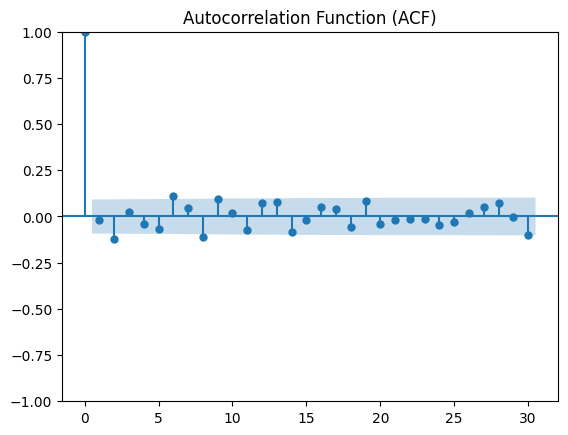

(449,)

In [173]:

data = prcTest
# Suppose 'returns_df' is a DataFrame with daily returns, columns = tickers
inst_target = 0
inst_prc = data[inst_target, :]
log_returns = np.diff(np.log(inst_prc))
plot_acf(log_returns, lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()
log_returns.shape

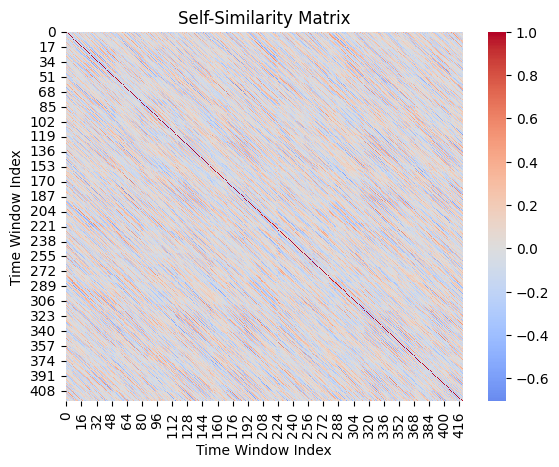

In [174]:
def self_similarity_matrix(series, window=30):
    """
    Computes correlation between all sliding windows of the time series.

    Returns:
        matrix (2D array): (n_windows x n_windows) correlation matrix
    """
    series = np.array(series)
    n = len(series) - window + 1
    matrix = np.empty((n, n))

    # Extract all sliding windows
    segments = np.array([series[i:i+window] for i in range(n)])

    for i in range(n):
        for j in range(n):
            matrix[i, j] = np.corrcoef(segments[i], segments[j])[0, 1]

    return matrix

# Compute and visualize
sim_matrix = self_similarity_matrix(log_returns, window=30)

sns.heatmap(sim_matrix, cmap='coolwarm', center=0)
plt.title("Self-Similarity Matrix")
plt.xlabel("Time Window Index")
plt.ylabel("Time Window Index")
plt.show()
